In [1]:
import numpy as np
from scipy.special import erf
import matplotlib.pyplot as plt

# Paprmeter definition
The following two functions represent two different approximation to obtain the deep kernel
 - function k_eff2 represents the deep kernel for 3-layer SE[SE[SE]]] using recursive way see Eq.(25) in paper
 - function k3 is obtained by treating the k2 as a piece-wise constant function see Eq(17)

Length scale in the first layer: $$c1 = \ell_1$$ 
Ratio between signal strength in layer 1 over length scale in layer 2: $$c2 = \frac{\sigma_1}{\ell_2}$$
Ratio between signal strength in layer 2 over length scale in layer 3: $$c3 = \frac{\sigma_2}{\ell_3}$$

In [2]:
def k_rbf(x,c):
    return np.exp((-1)*x**2/2/c**2)

def k1(x,c):
    return (1-np.exp((-1.)*x**2/2/c**2))

def k2(x,c1,c2):
    tmp1 = np.sqrt(k1(x,c1)) * np.sqrt(2) * c2
    tmp2 = tmp1**(-1)
    return erf(tmp2)

def k3(x,c1,c2,c3):
    tmp1 = 1/np.sqrt(1+2*c3**2)
    #return tmp1*k2((-1.)*x,c1,c2)+k2(x,c1,c2)
    return 1/np.sqrt(1+2*c3**2)+(1-1/np.sqrt(1+2*c3**2))*k2(x,c1,c2)

def k_eff1(x,c1,c2):
    return (np.sqrt(1+2*c2**2*k1(x,c1)))**(-1)

def k_eff2(x,c1,c2,c3):
    return (np.sqrt(1+2*c3**2*(1-k_eff1(x,c1,c2))))**(-1)

# Here we would like to define the distance backwardly from the kernel function
i.e. $$k(\Delta)=\exp(-\Delta^2/\ell^2)\Longrightarrow\Delta=\ell\sqrt{-\log k}$$

# For two-layer, the effective kernel leads to the new distance
$$\Delta_2=\ell\sqrt{0.5*\log[1+2c^2(1-k(\Delta))]}$$

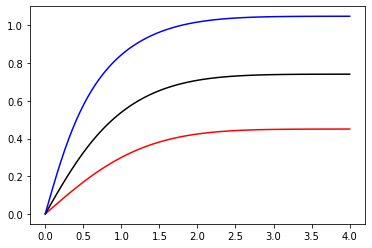

In [3]:
SIZE = 80
x_train = np.linspace(0.001, 4, SIZE)

plt.plot(x_train,np.sqrt(-np.log(k_eff1(x_train,1,0.5))),'r-')
plt.plot(x_train,np.sqrt(-np.log(k_eff1(x_train,1,1))),'k-')
plt.plot(x_train,np.sqrt(-np.log(k_eff1(x_train,1,2))),'b-')
plt.show()

# For 3-layer, same thing can be plotted

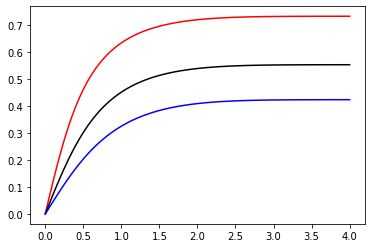

In [4]:
plt.plot(x_train,np.sqrt(-np.log(k_eff2(x_train,1,1.2,1.4))), 'r-')
plt.plot(x_train,np.sqrt(-np.log(k_eff2(x_train,1,1,1))),'k-')
plt.plot(x_train,np.sqrt(-np.log(k_eff2(x_train,1,0.8,0.8))), 'b-')
plt.show()

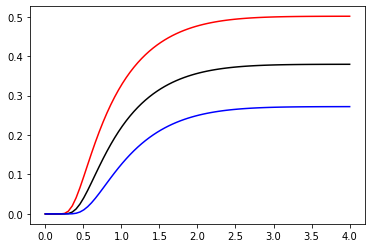

In [5]:
plt.plot(x_train,np.sqrt(-np.log(k3(x_train,1,1.2,1.4))), 'r-')
plt.plot(x_train,np.sqrt(-np.log(k3(x_train,1,1,1))),'k-')
plt.plot(x_train,np.sqrt(-np.log(k3(x_train,1,0.8,0.8))), 'b-')
plt.show()

In [6]:
from scipy.special.orthogonal import p_roots

In [7]:
def gauss1(f,n):
    [x,w] = p_roots(n+1)
    G=sum(w*f(x))
    return G

def gauss(f,n,a,b):
    [x,w] = p_roots(n+1)
    G=0.5*(b-a)*sum(w*f(0.5*(b-a)*x+0.5*(b+a)))
    return G

def my_f(x):
    return 2*x**2 - 3*x +15 

gauss(my_f,2,1,-1)

-31.33333333333333

# Gaussian Quadrature approximation for 3-layer deep kernels

$$ k_{eff}(\Delta) = \int e^{-h^2/2\sigma^2[1-k(\Delta)]} k_2(h,\sigma,\ell)$$

## The integral involving Gaussian measure can be approximated as

$$ \int_{-\infty}^{+\infty}e^{-x^2}f(x) = \frac{C_0}{\sqrt{\pi}} $$ 
where we have approximated the integrand as

$$ f(x) = \sum_{n=0}^NC_nH_n(x) $$ and H represents the Hermite polynomial.

## The zeroth coefficient has the following expression,
$$C_0 = \sqrt{\pi}\frac{f(-\sqrt{3/2})+6f(0)+f(\sqrt{3/2})}{6}$$

In [8]:
from scipy.special import roots_hermite

In [9]:
def gau1(p,x,c1,c2,c3):
    tmp1 = 1.-k_rbf(x,c1)
    tmp2 = 1.-np.exp(-1.*(p*c2)**2*tmp1)
    tmp3 = 1/(1+2*c3**2*tmp2)**0.5
    return tmp3

def Gauu(x,c1,c2,c3):
    tmp1 = 2/3*gau1(0,x,c1,c2,c3)
    tmp2 = 1/3*gau1(np.sqrt(3/2),x,c1,c2,c3)
    
    return tmp1+tmp2

def Gauuu(x,c1,c2,c3):
    tmp1 = 0.81026 * gau1(0,x,c1,c2,c3)
    tmp2 = 2*0.42561 * gau1(0.81629,x,c1,c2,c3)
    tmp3 = 2*0.05452 * gau1(1.67355,x,c1,c2,c3)
    tmp4 = 2*9.72E-04 * gau1(2.65196,x,c1,c2,c3)
    return (tmp1+tmp2+tmp3+tmp4)/np.sqrt(np.pi)

def GauQ(x,n,c1,c2,c3):
    [r,w] = roots_hermite(n)
    r=np.array(r).reshape(-1,1)
    w=np.array(w).reshape(-1,1)
    return sum(w*gau1(r,x,c1,c2,c3))/np.sqrt(np.pi)
    

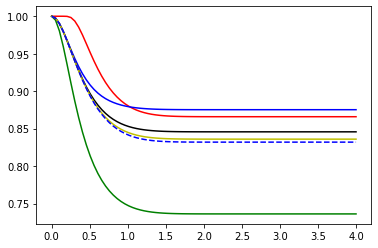

In [10]:
a = 0.5
b = 1
c = 1

plt.plot(x_train,k3(x_train,a,b,c),'r-')
plt.plot(x_train,k_eff2(x_train,a,b,c),'g-')
#plt.plot(x_train,Gauu(x_train,a,b,c),'k-')
plt.plot(x_train,GauQ(x_train,3,a,b,c),'b-')
plt.plot(x_train,GauQ(x_train,5,a,b,c),'k-')
plt.plot(x_train,GauQ(x_train,7,a,b,c),'y-')
plt.plot(x_train,GauQ(x_train,9,a,b,c),'b--')
plt.show()

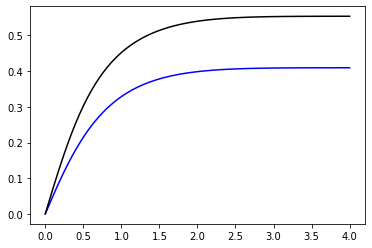

In [11]:
plt.plot(x_train,np.sqrt(-np.log(GauQ(x_train,5,1,1,1))),'b-')
plt.plot(x_train,np.sqrt(-np.log(k_eff2(x_train,1,1,1))),'k-')
plt.show()

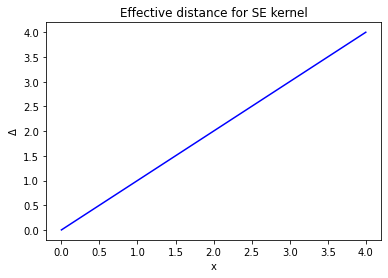

In [21]:
plt.plot(x_train,np.sqrt(2)*np.sqrt(-np.log(k_rbf(x_train,1))),'b-')
plt.xlabel('x')
plt.ylabel('$\Delta$')
plt.title('Effective distance for SE kernel')
plt.show()

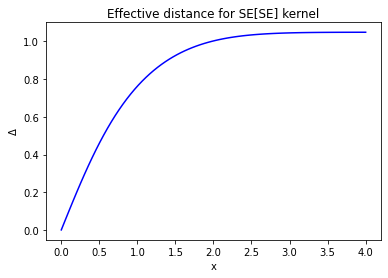

In [22]:
plt.plot(x_train,np.sqrt(2)*np.sqrt(-np.log(k_eff1(x_train,1,1))),'b-')
plt.xlabel('x')
plt.ylabel('$\Delta$')
plt.title('Effective distance for SE[SE] kernel')
plt.show()

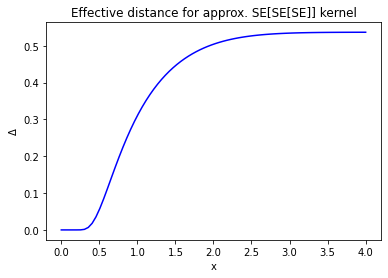

In [23]:
plt.plot(x_train,np.sqrt(2)*np.sqrt(-np.log(k3(x_train,1,1,1))),'b-')
plt.xlabel('x')
plt.ylabel('$\Delta$')
plt.title('Effective distance for approx. SE[SE[SE]] kernel')
plt.show()